In [1]:
from import_all import *
from utilities import *


In [2]:
#----Connect to instrument----#
#load the station from yaml configuration file
station = Station(config_file="electrochemistry.station.yaml")
keithley1 = station.load_keithley1()
keithley2 = station.load_keithley2()

Connected to: Keithley Instruments Inc. 2636B (serial:4629010, firmware:3.4.0) in 0.24s
Connected to: Keithley Instruments Inc. 2614B (serial:4070377, firmware:3.0.4) in 0.13s


In [3]:
#----Save paths----#
csv_save_path = "./csv/test/"
db_save_path = "./db/test/"
device_name = "test" #master database file
xpmnt_name = "test" #"sparseMap_sparseNm0-6to-06_cutE1-4V_20mVs_ds50mV"#

In [19]:
####################################
#----Configure channels----#
####################################

top_gate = { "channel": keithley1.smua,
        "name": "top_gate",
        "max_voltage": 0.2,
        "min_voltage": -0.2,
        "n": 41,
        "independent":  True, # default = True             
}

bottom_gate = { "channel": keithley1.smub,
        "name": "bottom_gate",
        "max_voltage": 0.2,
        "min_voltage": -0.2,
        "n": 41,
        "independent":  True, # default = True        
}


drain_source = { "channel": keithley2.smub,
        "name": "drain_source",
        "max_voltage":0.1,
        "min_voltage": 0.1,
        "n": 1,
        "independent":  False, # default = False         
}

####################################
#----Configure sweeping params----#
####################################

#----sparse maps, and/or maps with truncated EField ----#
sparse = True #sparse: map through E with designated number of charge-carrier density values
sparse_N=  3 #201 #401  #sparse_N should be odd to include both max and min values
truncate_N = 1 #70#7 #120 #how many vt+vb points to take off on each side

cutEField = True #True
thresholdE = 0.4 #threshold E field (vt - vb)

#----map forward and back? Recommended to map both directions if repeating----#
map_forward = True # Map scan forward, map scan backward
map_backward = False

########----Scanning parameters----######
dt = 1
delayNPLC_ratio = 0.8
n_measurements = 6

start_delay = 2 #time between setting initial voltages and beginning scan
round_delay=2 #round delay is the delay built in between succesive loops through intercepts (each back-forward trace)
repeat=2 #how many times to repeat entire map
forward_write_period = 2 
back_write_period = 2
round_ramp =True #ramp to new configuration each time vt+vb changes? Useful for sparse map, unecessary for full map

sweepers = [top_gate, bottom_gate, drain_source]
sweepers_save_order = [top_gate, bottom_gate, drain_source] #Order for saving in database, for easy parsing of data in plottr-inspectr
channels_save_order = [top_gate["channel"], bottom_gate["channel"], drain_source["channel"]] #Order for saving in database, for easy parsing of data in plottr-inspectr


In [20]:
delay = dt*delayNPLC_ratio/n_measurements
nplc_set = dt*50*(1-delayNPLC_ratio)/(n_measurements)

sweepers_save_order[0]["channel"].delay(3*delay)
sweepers_save_order[0]["channel"].nplc(nplc_set)

for sweeper in sweepers_save_order[1:]:
    sweeper["channel"].delay(0)
    sweeper["channel"].nplc(nplc_set)

In [21]:
for sweeper in sweepers:
    print(f'----{sweeper["name"]}----')
    dVoltage = (sweeper["max_voltage"]-sweeper["min_voltage"])/sweeper["n"]
    if dVoltage ==0:
        print(f'Keeping {sweeper["name"]} fixed at {sweeper["min_voltage"]} V')
        continue
    dVoltage = (sweeper["max_voltage"]-sweeper["min_voltage"])/(sweeper["n"]-1)
    print(f'Will scan {sweeper["name"]} from {sweeper["max_voltage"]} to {sweeper["min_voltage"]} in {1000*dVoltage} mV steps')   
    print(f'Scan speed for {sweeper["name"]}: {1000 * dVoltage/dt} mV/s')


----top_gate----
Will scan top_gate from 0.2 to -0.2 in 10.0 mV steps
Scan speed for top_gate: 10.0 mV/s
----bottom_gate----
Will scan bottom_gate from 0.2 to -0.2 in 10.0 mV steps
Scan speed for bottom_gate: 10.0 mV/s
----drain_source----
Keeping drain_source fixed at 0.1 V


passing through [0.] intercepts, corresponds to charge carrier density (Vb + Vt)
Total time = 0.02277777777777778 hrs
0.4


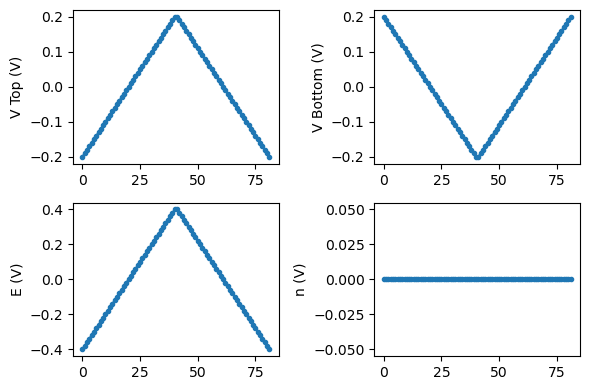

In [22]:

%matplotlib inline
#####Make arrays and plot vs time ##########

diag = DiagonalSource('diagonal', top_gate["channel"].volt, bottom_gate["channel"].volt)
intercept = DiagonalIntercept('intercept', diag, 0)

xrange = np.linspace(top_gate["min_voltage"], top_gate["max_voltage"], top_gate["n"])
yrange = np.linspace(bottom_gate["min_voltage"], bottom_gate["max_voltage"], bottom_gate["n"])
ny = yrange.size
ni = (ny-1)*2+1

intercepts = np.linspace(
    yrange.min()-xrange.min()*diag.slope,
    yrange.max()-xrange.max()*diag.slope,
    ni
    )

sweep_points = []
for i, inter in enumerate(intercepts):
    # Get correct range of x values
    if i < ny:
        xset = xrange[0:i+1]
    else:
        xset = xrange[i+1-ny::]
    sweep_points.append(xset)

if sparse:
    intercepts, sweep_points = sparse_intercepts(intercepts, sweep_points, sparse_N, truncate_N)
    print(f'passing through {intercepts} intercepts, corresponds to charge carrier density (Vb + Vt)')

if cutEField:
    sweep_points = cutE(diag, intercept, intercepts, sweep_points, thresholdE)

plot_diagonals(intercepts, sweep_points, diag, intercept)

In [23]:


#----Connect to database----#
initialise_or_create_database_at(f'{db_save_path}{device_name}_{xpmnt_name}_mapping.db')
#Set up experiment object
test_exp = load_or_create_experiment(
    experiment_name="test",
    sample_name="test",
)

meas_forward, meas_back, time = setup_database_registers_inPlane(station, test_exp, sweepers_save_order)
meas_forward.write_period = forward_write_period
meas_back.write_period = back_write_period

In [24]:
#----Run Mapping----#
#ramp voltages to initial values, from 0
#initial values: 


x_initial = sweep_points[0][0]
intercept(intercepts[0])
y_initial = diag.slope*x_initial + intercept()

x_current = top_gate["channel"].volt()
y_current = bottom_gate["channel"].volt()

print('-----Set DACs to initial values and set DS-----')
ramp_two_voltage(top_gate["channel"],bottom_gate["channel"], x_initial, y_initial, x_initial = x_current, y_initial = y_current, reset=False) # ramp to initial voltages

print(f'Setting DS voltage to {drain_source["max_voltage"]} V')
ramp_voltage(drain_source["channel"],drain_source["max_voltage"])

print('-----Begin sweeps-----')
sleep(start_delay)
time.reset_clock()
with meas_forward.run() as forward_saver:
    with meas_back.run() as back_saver:
        for _ in range(repeat):
            first_sweep = True
            print(f'Repeat: {_+1}')
            if map_forward:
                for inter, xrange in zip(intercepts, sweep_points):
                    intercept(inter)
                    first_sweep = True
                    for x in xrange:
                        y = diag.slope*x + intercept()
                        if first_sweep and round_ramp:
                            print(f'-----Ramping to next configuration: x = {x} v, y = {y} v -----')
                            ramp_two_voltage(top_gate["channel"],bottom_gate["channel"], x, y, reset = False,
                                            x_initial = top_gate["channel"].volt(), y_initial = bottom_gate["channel"].volt())
                            print('-----Starting sweep-----')
                            first_sweep = False
                            sleep(round_delay)
                        else:
                            diag(x)
                        record_data(top_gate["channel"].volt(), bottom_gate["channel"].volt(), time,*channels_save_order, forward_saver)
                    for x in xrange[::-1]:
                        y = diag.slope*x + intercept()
                        diag(x)
                        record_data(top_gate["channel"].volt(), bottom_gate["channel"].volt(), time, *channels_save_order, back_saver)
                    
            if map_backward:
                for inter, xrange in zip(intercepts[::-1], sweep_points[::-1]):
                    intercept(inter)
                    first_sweep = True
                    for x in xrange:
                        y = diag.slope*x + intercept()
                        if first_sweep and round_ramp:
                            print(f'-----Ramping to next configuration: x = {x} v, y = {y} v -----')
                            ramp_two_voltage(top_gate["channel"],bottom_gate["channel"], x, y, reset = False,
                                            x_initial = top_gate["channel"].volt(), y_initial = bottom_gate["channel"].volt())
                            print('-----Starting sweep-----')
                            first_sweep = False
                            sleep(round_delay)
                        else:
                            diag(x)
                        record_data(top_gate["channel"].volt(), bottom_gate["channel"].volt(), time, *channels_save_order, forward_saver)
                    for x in xrange[::-1]:
                        y = diag.slope*x + intercept()
                        diag(x)
                        record_data(top_gate["channel"].volt(), bottom_gate["channel"].volt(), time, *channels_save_order, back_saver)

            data_forward = forward_saver.dataset
            data_back = back_saver.dataset

#save data to csv
data_forward.to_pandas_dataframe().to_csv(f"{csv_save_path}{device_name}_{xpmnt_name}_forward_{data_forward.run_id}.csv")
data_back.to_pandas_dataframe().to_csv(f"{csv_save_path}{device_name}_{xpmnt_name}_back_{data_back.run_id}.csv")

#Ramping voltage back to 0
x_current = top_gate["channel"].volt()
y_current = bottom_gate["channel"].volt()
ramp_two_voltage(top_gate["channel"],bottom_gate["channel"], -1, -1, x_initial = x_current, y_initial = y_current, reset=False)
ramp_voltage(drain_source["channel"],0)



-----Set DACs to initial values and set DS-----
ramping <Keithley2600Channel: keithley1_smua of Keithley2600: keithley1> and <Keithley2600Channel: keithley1_smub of Keithley2600: keithley1> to -0.2 and 0.2
Setting DS voltage to 0.1 V
ramping <Keithley2600Channel: keithley2_smub of Keithley2600: keithley2> from 6.67572e-06 to 0.1
-----Begin sweeps-----
Starting experimental run with id: 5. 
Starting experimental run with id: 6. 
Repeat: 1
-----Ramping to next configuration: x = -0.2 v, y = 0.2 v -----
ramping <Keithley2600Channel: keithley1_smua of Keithley2600: keithley1> and <Keithley2600Channel: keithley1_smub of Keithley2600: keithley1> to -0.2 and 0.2
-----Starting sweep-----
Repeat: 2
-----Ramping to next configuration: x = -0.2 v, y = 0.2 v -----
ramping <Keithley2600Channel: keithley1_smua of Keithley2600: keithley1> and <Keithley2600Channel: keithley1_smub of Keithley2600: keithley1> to -0.2 and 0.2
-----Starting sweep-----
ramping <Keithley2600Channel: keithley1_smua of Keithl